# 1.Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc 
import platform

# 그래프에서 한글을 표기하기 위해 글꼴 변경 
if platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family=font_name)
elif platform.system() == 'Darwin':   # macOS
    rc('font',family = 'AppleGothic')
else:
    print('Check your OS system')

Check your OS system


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
used_car = pd.read_excel('/content/drive/MyDrive/multicampus/project2/데이터/used_car_ver8.xlsx')
used_car.head(3)

,Unnamed: 0,제조사,모델,이름,연도,주행거리,연료,배기량,색상,보증정보,...,옵션_파노라마선루프,옵션_열선앞,옵션_열선뒤,옵션_전방센서,옵션_후방센서,옵션_전방캠,옵션_후방캠,옵션_어라운드뷰,옵션_네비순정,보험이력
0,0,2,49,쉐보레 더 뉴 스파크 1.0 프리미어,2021,16250,2,999,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,1,5,86,현대 올 뉴 투싼 1.6 디젤 2WD 스마트,2018,67696,6,1598,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2,2,0,42,기아 더 뉴 봉고3 캠핑카 -,2020,29000,6,2497,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# 2.데이터 전처리

* 가격 로그 변환
  * 정규 분포를 위해 로그 변환 진행

In [6]:
used_car['로그_가격'] = np.log1p(used_car['가격'])

Text(0.5, 1.0, 'After log')

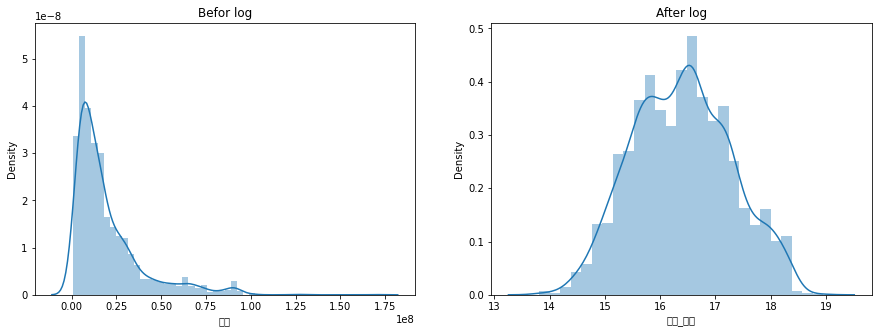

In [8]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.distplot(used_car['가격'], ax = ax1)
ax1.set_title('Befor log')

sns.distplot(used_car['로그_가격'], ax = ax2)
ax2.set_title('After log')

* 배기량, 주행 거리 정규화
  * 단위가 크기 때문에 정규화 진행

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler()
used_car['배기량_정규화'] = scaler1.fit_transform(used_car[['배기량']])

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler1 = MinMaxScaler()
used_car['주행거리_정규화'] = scaler1.fit_transform(used_car[['주행거리']])

#### 주행거리 노이즈 제거

* 노이즈 제거 전

45000.0
136266.0


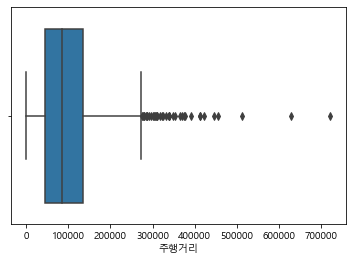

In [ ]:
sns.boxplot(used_car.주행거리)
q1 = used_car["주행거리"].quantile(0.25)
print(q1)
q3 = used_car["주행거리"].quantile(0.75)
print(q3)

In [ ]:
coef = q3 - q1
upper = q3 + 1.5*coef
lower = q1 - 1.5*coef
condition = (used_car["주행거리"] > upper) | (used_car["주행거리"] < lower)
ind = used_car.주행거리[condition].index
used_car.drop(ind,axis=0,inplace = True)

* 노이즈 제거 후

<AxesSubplot:xlabel='주행거리'>

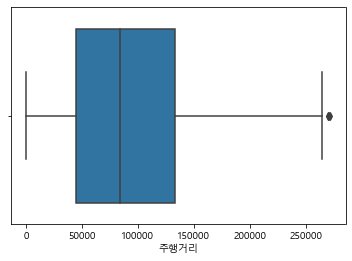

In [ ]:
sns.boxplot(used_car.주행거리)

#### 배기량 노이즈 제거

* 노이즈 제거 전

1685.0
2497.0


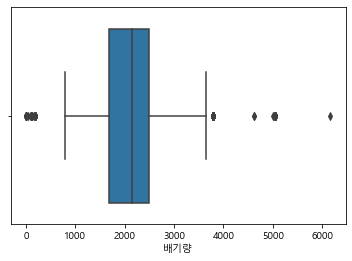

In [ ]:
sns.boxplot(used_car.배기량)
q1 = used_car["배기량"].quantile(0.25)
print(q1)
q3 = used_car["배기량"].quantile(0.75)
print(q3)

In [ ]:
coef = q3 - q1
upper = q3 + 1.5*coef
condition = (used_car["배기량"] > upper)
ind = used_car.배기량[condition].index
used_car.drop(ind,axis=0,inplace = True)
used_car["배기량"][used_car["배기량"] == 0] = 1e-07

min(used_car["배기량"])

1e-07

* 노이즈 제거 후

<AxesSubplot:xlabel='배기량'>

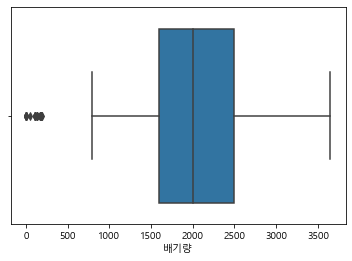

In [ ]:
sns.boxplot(used_car.배기량)

#### 가격 노이즈 제거

15.671808704579888
16.785925074816024


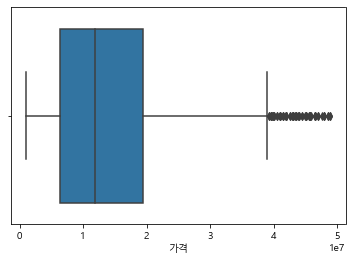

In [ ]:
sns.boxplot(used_car.가격)
q1 = used_car["로그_가격"].quantile(0.25)
print(q1)
q3 = used_car["로그_가격"].quantile(0.75)
print(q3)

In [ ]:
coef = q3 - q1
upper = q3 + 1.5*coef
lower = q1 - 1.5*coef
condition = (used_car["로그_가격"] > upper) | (used_car["로그_가격"] < lower)
ind = used_car.로그_가격[condition].index
used_car.drop(ind,axis=0,inplace = True)

<AxesSubplot:xlabel='로그_가격'>

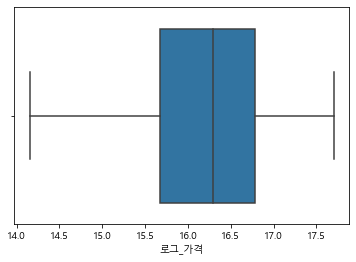

In [ ]:
sns.boxplot(used_car.로그_가격)

In [ ]:
used_car.shape

(2129, 26)

<Axes: >

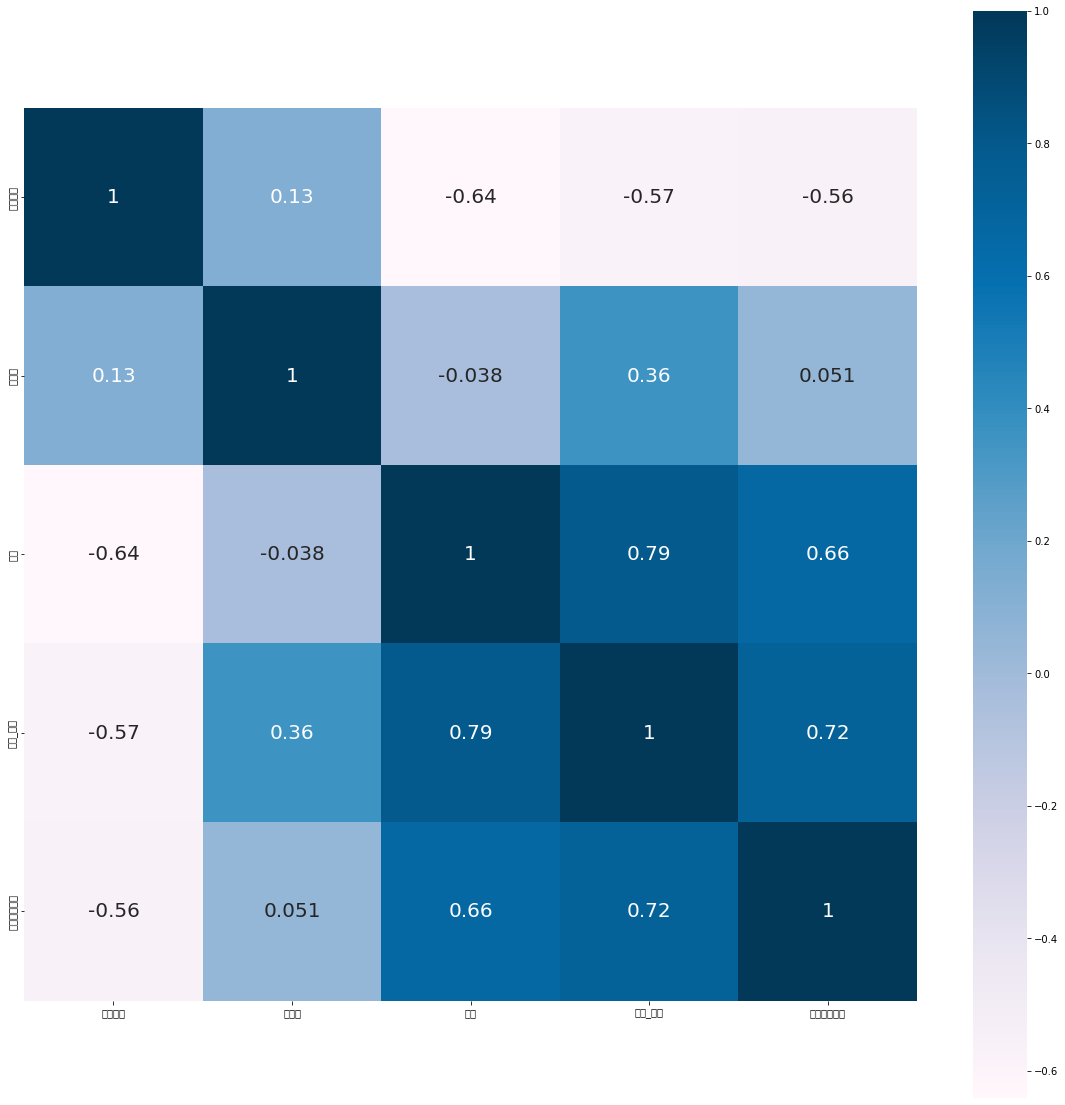

In [22]:
used_car = used_car[['주행거리','배기량','연도','로그_가격','신차대비가격']]

plt.figure(figsize = (20, 20))
sns.heatmap(used_car.corr(),annot=True, square = True, annot_kws = {'size':20}, cmap='PuBu')

# 3.모델링

In [ ]:
from sklearn.model_selection import train_test_split

X = used_car[['제조사','모델','연도','주행거리','연료','배기량','색상','보증정보','신차대비가격','보험이력']]
y = used_car['로그_가격']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 2045)

print('Train Data : ', X_train.shape, y_train.shape)
print('Test Data : ', X_test.shape, y_test.shape)

Train Data :  (1488, 10) (1488,)
Test Data :  (638, 10) (638,)


In [ ]:
from sklearn.linear_model import LinearRegression

MR = LinearRegression()
MR.fit(X_train, y_train)

LinearRegression()

In [ ]:
print('weight(w) : ', MR.coef_)
print('bias(b) : ', MR.intercept_)

weight(w) :  [ 8.95169269e-03 -2.54272517e-03  1.05804317e-01 -1.52708562e-06
  6.25353640e-02  3.93324810e-04  7.28684660e-03  6.67967605e-02
  6.79186851e-03  1.38896422e-01]
bias(b) :  -198.20264013165715


In [ ]:
MR.score(X_test, y_test)

0.81479270206393

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

MR_mse = mean_squared_error(np.expm1(y_test),np.expm1(MR.predict(X_test)))
MR_rmse = np.sqrt(MR_mse)
MR_r2 = r2_score(np.expm1(y_test),np.expm1(MR.predict(X_test)))

print('MR mse :', MR_mse)
print('MR rmse :', MR_rmse)
print('MR r^2 :', MR_r2)

MR mse : 33665704812618.82
MR rmse : 5802215.508977482
MR r^2 : 0.6939986451014877


#### Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge

RG = Ridge(normalize = True, 
           alpha = 0.3,
           solver = 'cholesky')   

RG.fit(X_train, y_train)

Ridge(alpha=0.3, normalize=True, solver='cholesky')

In [ ]:
RG.score(X_test, y_test)

0.7846058276125462

In [ ]:
RGmse = mean_squared_error(np.expm1(y_test),np.expm1(RG.predict(X_test)))
RGrmse = np.sqrt(RGmse)
RGr2 = r2_score(np.expm1(y_test),np.expm1(RG.predict(X_test)))

print('RG mse :', RGmse)
print('RG rmse :', RGrmse)
print('RG r^2 :', RGr2)

RG mse : 35052019563322.92
RG rmse : 5920474.606256066
RG r^2 : 0.6813978635526564


#### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

LS = Lasso(normalize = True, 
           alpha = 0.2)
   
LS.fit(X_train, y_train)

Lasso(alpha=0.2, normalize=True)

In [ ]:
LS.score(X_test, y_test)

-0.0026897505089342744

In [ ]:
LSmse = mean_squared_error(np.expm1(y_test),np.expm1(LS.predict(X_test)))
LSrmse = np.sqrt(LSmse)
LSr2 = r2_score(np.expm1(y_test),np.expm1(LS.predict(X_test)))

print('LS mse :', LSmse)
print('LS rmse :', LSrmse)
print('LS r^2 :', LSr2)

LS mse : 124843587215467.84
LS rmse : 11173342.70554107
LS r^2 : -0.1347544051418308


#### ElasticNet Regression

In [ ]:
from sklearn.linear_model import ElasticNet

EN = ElasticNet(normalize = True, 
                alpha = 0.001,
                l1_ratio = 0.7)
   
EN.fit(X_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.7, normalize=True)

In [ ]:
EN.score(X_test, y_test)

0.7416776228852675

In [ ]:
ENmse = mean_squared_error(np.expm1(y_test),np.expm1(EN.predict(X_test)))
ENrmse = np.sqrt(ENmse)
ENr2 = r2_score(np.expm1(y_test),np.expm1(EN.predict(X_test)))

print('EN mse :', ENmse)
print('EN rmse :', ENrmse)
print('EN r^2 :', ENr2)

EN mse : 41771613440053.125
EN rmse : 6463096.27346314
EN r^2 : 0.6203207275743101


#### Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DTR = DecisionTreeRegressor(max_depth = 5,
                            criterion ='mse',
                            random_state = 1215)

DTR.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, random_state=1215)

In [ ]:
DTR.score(X_test, y_test)

0.8603853077559573

In [ ]:
DTRmse = mean_squared_error(np.expm1(y_test),np.expm1(DTR.predict(X_test)))
DTRrmse = np.sqrt(DTRmse)
DTRr2 = r2_score(np.expm1(y_test),np.expm1(DTR.predict(X_test)))

print('DTR mse :', DTRmse)
print('DTR rmse :', DTRrmse)
print('DTR r^2 :', DTRr2)

DTR mse : 26484989349615.69
DTR rmse : 5146356.9007226555
DTR r^2 : 0.7592671037020052


In [ ]:
DTR.feature_importances_

array([0.        , 0.03058334, 0.00126255, 0.01114772, 0.00883185,
       0.1570564 , 0.        , 0.        , 0.79111814, 0.        ])

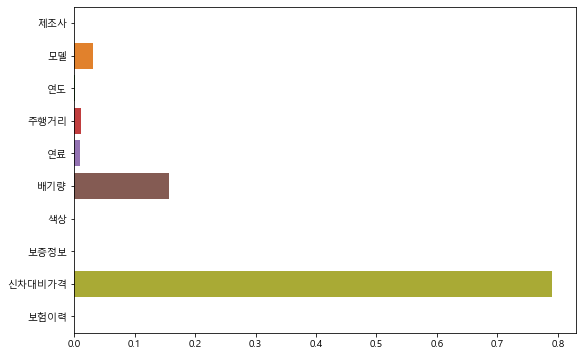

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(DTR.feature_importances_,
            ['제조사', '모델','연도', '주행거리', '연료','배기량','색상','보증정보','신차대비가격','보험이력'])
plt.show()

#### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators = 2000,
                            max_features = 3,
                            max_depth = 1,
                            criterion ='mse',
                            n_jobs = -1,
                            random_state = 1215)

RFR.fit(X_train, y_train)

RandomForestRegressor(criterion='mse', max_depth=1, max_features=3,
                      n_estimators=2000, n_jobs=-1, random_state=1215)

In [ ]:
RFR.score(X_test, y_test)

0.49960361701967815

In [ ]:
RFRmse = mean_squared_error(np.expm1(y_test),np.expm1(RFR.predict(X_test)))
RFRrmse = np.sqrt(RFRmse)
RFRr2 = r2_score(np.expm1(y_test),np.expm1(RFR.predict(X_test)))

print('RFR mse :', RFRmse)
print('RFR rmse :', RFRrmse)
print('RFR r^2 :', RFRr2)

RFR mse : 76466552055428.27
RFR rmse : 8744515.541493895
RFR r^2 : 0.3049642458515204


In [ ]:
RFR.feature_importances_

array([0.018 , 0.048 , 0.2305, 0.1705, 0.0185, 0.087 , 0.    , 0.1275,
       0.3   , 0.    ])

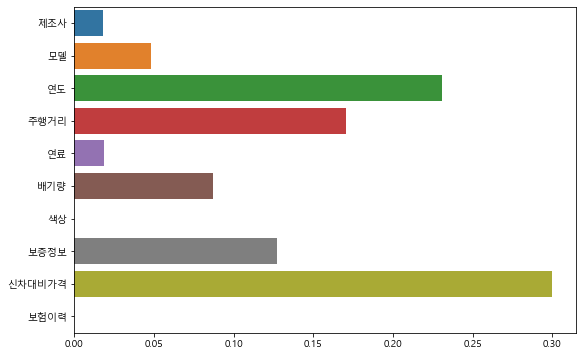

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(RFR.feature_importances_,
            ['제조사', '모델','연도', '주행거리', '연료','배기량','색상','보증정보','신차대비가격','보험이력'])
plt.show()

#### Gradient Boosting Machine(GBM) Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(loss = 'ls',
                                n_estimators = 9000,
                                learning_rate = 0.0001,
                                criterion ='mse',
                                max_features = 3,
                                max_depth = 1,
                                random_state = 1215)

GBR.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.0001, loss='ls',
                          max_depth=1, max_features=3, n_estimators=9000,
                          random_state=1215)

In [ ]:
GBR.score(X_test, y_test)

0.3943632022987331

In [ ]:
GBRmse = mean_squared_error(np.expm1(y_test),np.expm1(GBR.predict(X_test)))
GBRrmse = np.sqrt(GBRmse)
GBRr2 = r2_score(np.expm1(y_test),np.expm1(GBR.predict(X_test)))

print('GBR mse :', GBRmse)
print('GBR rmse :', GBRrmse)
print('GBR r^2 :', GBRr2)

GBR mse : 89116407728854.69
GBR rmse : 9440148.71328067
GBR r^2 : 0.18998453588007624


In [ ]:
GBR.feature_importances_

array([0.00075468, 0.01165338, 0.3134294 , 0.12900878, 0.00318204,
       0.03045584, 0.        , 0.06049667, 0.45101922, 0.        ])

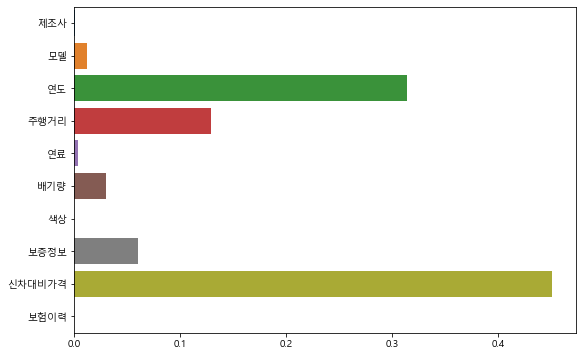

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(GBR.feature_importances_,
            ['제조사', '모델','연도', '주행거리', '연료','배기량','색상','보증정보','신차대비가격','보험이력'])
plt.show()

#### Adaptive Boosting Regressor

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ABR = AdaBoostRegressor(loss = 'square',
                        n_estimators = 500,
                        learning_rate = 0.0001,
                        random_state = 1215)

ABR.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.0001, loss='square', n_estimators=500,
                  random_state=1215)

In [ ]:
ABRmse = mean_squared_error(np.expm1(y_test),np.expm1(ABR.predict(X_test)))
ABRrmse = np.sqrt(ABRmse)
ABRr2 = r2_score(np.expm1(y_test),np.expm1(ABR.predict(X_test)))

print('ABR mse :', ABRmse)
print('ABR rmse :', ABRrmse)
print('ABR r^2 :', ABRr2)

ABR mse : 41886869154759.42
ABR rmse : 6472006.578701803
ABR r^2 : 0.6192731212623013


In [ ]:
ABR.feature_importances_

array([0.00000000e+00, 4.63342996e-04, 4.56349912e-03, 6.66593689e-04,
       3.23573059e-05, 1.07612795e-01, 0.00000000e+00, 0.00000000e+00,
       8.86661412e-01, 0.00000000e+00])

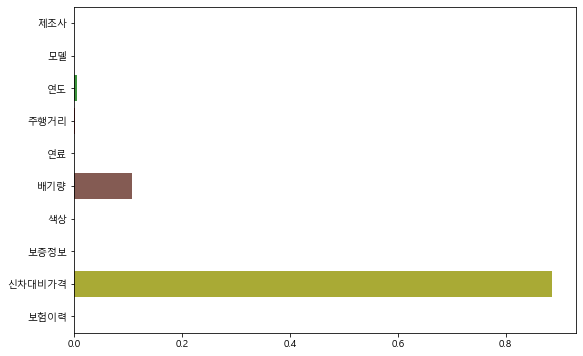

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(ABR.feature_importances_,
            ['제조사', '모델','연도', '주행거리', '연료','배기량','색상','보증정보','신차대비가격','보험이력'])
plt.show()

#### 모델 비교

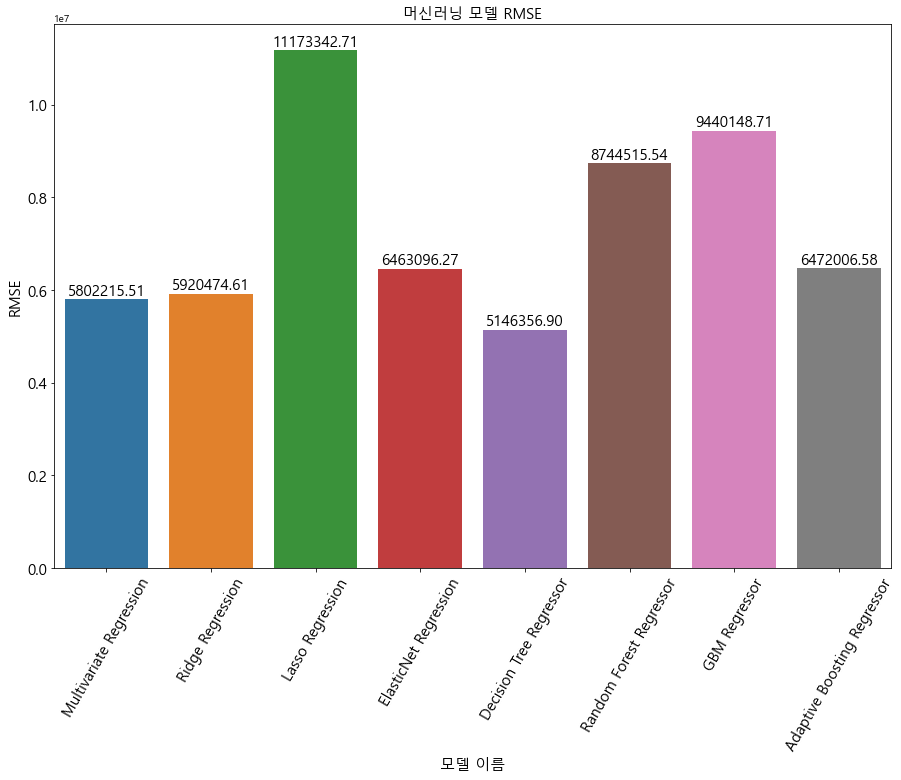

In [ ]:
Model_Name = ['Multivariate Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet Regression', 'Decision Tree Regressor',
              'Random Forest Regressor', 'GBM Regressor', 'Adaptive Boosting Regressor']
Model_Score = [MR_rmse, RGrmse, LSrmse, ENrmse, DTRrmse, RFRrmse, GBRrmse, ABRrmse]
plt.figure(figsize = (15,10))
plt.title("머신러닝 모델 RMSE", size = 15)
plt.xlabel("모델 이름", size = 15)
plt.ylabel("RMSE", size = 15)
plt.xticks(size = 15, rotation=60)
plt.yticks(size = 15)
ax = sns.barplot(Model_Name, Model_Score)
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')